In [2]:
# %%
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import argparse
from tools.analysis.statistical_analysis_tools import *
import os
import logging

# %%
from pypalettes import load_cmap
alexandrite = load_cmap("Alexandrite")
emrld = load_cmap("Emrld", reverse=True)

# %%

DATA_DIR = os.path.join("../data")
FIGURES_DIR = os.path.join("../reports/figures")

In [4]:
logging.basicConfig(level=logging.INFO)
dataset_name = 'hepatitis'

# %%
logging.info(f"Loading results data for {dataset_name}")
knn_results_filename = f"{DATA_DIR}/cross_validated_results/knn_{dataset_name}.csv"
knn_reduction_results_filename = f"{DATA_DIR}/cross_validated_results/knn_reduction_{dataset_name}.csv"
svm_results_filename = f"{DATA_DIR}/cross_validated_results/svm_{dataset_name}.csv"

knn_results = pd.read_csv(knn_results_filename)
knn_reduction_results = pd.read_csv(knn_reduction_results_filename)
svm_results = pd.read_csv(svm_results_filename)

# %%
fold_cols = [f"fold{i}" for i in range(10)]

for df in [knn_results, knn_reduction_results, svm_results]:
    df.sort_values(by="train_time", ascending=False, inplace=True)

knn_results["model_label"] = knn_results.apply(get_knn_model_label, axis=1)
knn_reduction_results["model_label"] = knn_reduction_results.apply(
    get_knn_reduction_model_label, axis=1
)
svm_results["model_label"] = svm_results.apply(get_svm_model_label, axis=1)


INFO:root:Loading results data for hepatitis


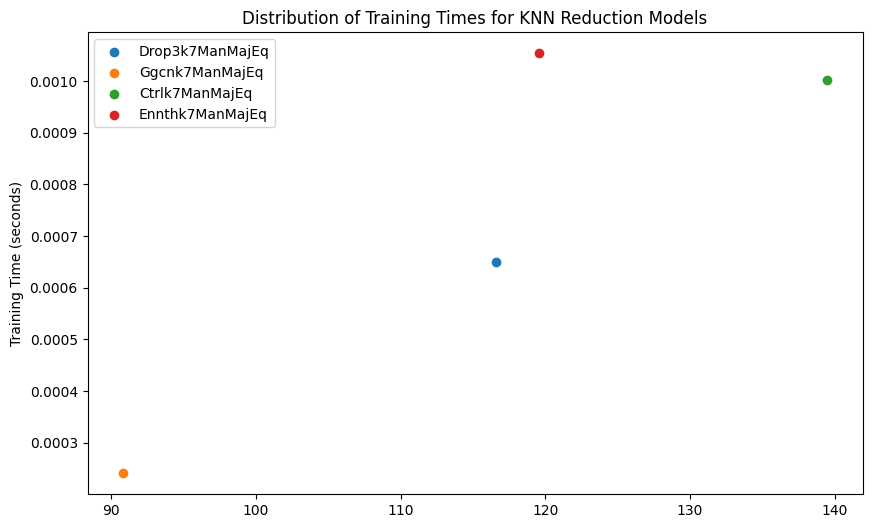

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
for _, result in knn_reduction_results.iterrows():
    ax.scatter(result['storage'], result['train_time'], label=result['model_label'])
ax.legend()
plt.title('Distribution of Training Times for KNN Reduction Models')
plt.ylabel('Training Time (seconds)')
plt.show()

In [ ]:
# %%
logging.info("Running Friedman test across all models and sampling methods")
num_sample_options = [4, 8, 16]
sample_types = ["linear", "top"]
models = ["KNN", "SVM", "KNN-Reduction"]
dataframes = [knn_results, svm_results, knn_reduction_results]
data = []

for sample_type, num_samples, (model, df) in itertools.product(
    sample_types, num_sample_options, zip(models, dataframes)
):
    sample_func = linear_sample if sample_type == "linear" else top_samples

    p_value = friedman_test(sample_func(df, num_samples), fold_cols)[1]
    data.append(
        {
            "model": model,
            "num_samples": num_samples,
            "sample_type": sample_type,
            "p_value": p_value,
            "significant": p_value < 0.05,
        }
    )

p_values_df = pd.DataFrame(data)

p_values_df

# %%
# TODO: only plot one point for KNN-Reduction
logging.info("Plotting p-values vs number of samples")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(
    f"P-values vs Number of Samples for Different Models and Sampling Methods for {dataset_name} dataset",
    fontsize=20,
    fontweight="bold",
)

plot_p_values_vs_num_samples(axes, p_values_df, models, sample_types, num_sample_options)

plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/p_values_vs_num_samples_{dataset_name}.png", dpi=300)
plt.show()


# %%
logging.info("Plotting independent effects of KNN model parameters")
fig = plot_independent_effects(
    knn_results, ["k", "distance_func", "voting_func", "weighting_func"]
)
fig.suptitle(
    f"Independent Effects of KNN Model Parameters on F1 Score for {dataset_name} dataset",
    fontsize=16,
    fontweight="bold",
)
fig.subplots_adjust(top=0.9)
fig.savefig(f"{FIGURES_DIR}/independent_effects_KNN_{dataset_name}.png", dpi=300)
plt.show()


# %%
logging.info("Plotting independent effects of SVM model parameters")
fig = plot_independent_effects(svm_results, ["C", "kernel_type"])
fig.suptitle(
    f"Independent Effects of SVM Model Parameters on F1 Score for {dataset_name} dataset",
    fontsize=16,
    fontweight="bold",
)
fig.subplots_adjust(top=0.85)
fig.savefig(f"{FIGURES_DIR}/independent_effects_SVM_{dataset_name}.png", dpi=300)
plt.show()

# %%
logging.info("Plotting interaction effects of KNN model parameters")
fig = plot_interactions(knn_results, ["k", "distance_func", "voting_func", "weighting_func"])
fig.suptitle(
    f"Interaction Effects of KNN Model Parameters on F1 Score for {dataset_name} dataset",
    fontsize=20,
    fontweight="bold",
)
fig.subplots_adjust(top=0.95)
fig.savefig(f"{FIGURES_DIR}/interaction_effects_KNN_{dataset_name}.png", dpi=300)
plt.show()

knn_col_names = ["k", "distance_func", "voting_func", "weighting_func"]
top_values = get_top_values(knn_results, knn_col_names, num_to_select=2, models_to_consider=10)

models_with_top_values = get_models_with_top_values(knn_results, top_values)

# %%

# %%
logging.info("Plotting ranked folds distribution for KNN models")
knn_ranked_folds = get_ranked_folds(linear_sample(knn_results, 8), fold_cols)
fig, ax = plt.subplots(figsize=(12, 6))
plot_ranked_folds(ax, knn_ranked_folds, fold_cols)
fig.suptitle(
    f"Ranked Folds Distribution for KNN Models for {dataset_name} dataset",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/ranked_folds_KNN_{dataset_name}.png", dpi=300)
plt.show()

# %%
logging.info("Plotting ranked folds distribution for SVM models")
svm_ranked_folds = get_ranked_folds(linear_sample(svm_results, 8), fold_cols)
fig, ax = plt.subplots(figsize=(12, 6))
plot_ranked_folds(ax, svm_ranked_folds, fold_cols)
fig.suptitle(
    f"Ranked Folds Distribution for SVM Models for {dataset_name} dataset",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/ranked_folds_SVM_{dataset_name}.png", dpi=300)
plt.show()

# %%
logging.info("Running Nemenyi test for KNN models")
results_for_nemenyi = linear_sample(knn_results, 8)
nemenyi_results = nemenyi_test(results_for_nemenyi, fold_cols)
nemenyi_results


# %%
logging.info("Plotting Nemenyi test results for KNN models")
fig, ax = plt.subplots(figsize=(12, 12))
model_labels = results_for_nemenyi["model_label"]
sns.heatmap(
    nemenyi_results,
    fmt=".2f",
    annot=True,
    cmap=emrld,
    ax=ax,
    cbar=False,
    xticklabels=model_labels,
    yticklabels=model_labels,
)
fig.suptitle(
    f"Nemenyi Test Results for KNN Models for {dataset_name} dataset",
    fontsize=20,
    fontweight="bold",
)
fig.savefig(f"{FIGURES_DIR}/nemenyi_test_results_KNN_{dataset_name}.png", dpi=300)
plt.tight_layout()
plt.show()

# %%
logging.info("Analyzing Nemenyi test results for KNN models")
analyze_parameters(results_for_nemenyi, nemenyi_results)

# significant_pairs_df = get_significant_pairs(nemenyi_results, results_for_nemenyi)
